# Dataset

> Scripts to build the different datasets used for modeling

In [1]:
#| default_exp dataset

In [27]:
#| export
#| hide
import os
import h5py
import numpy as np
import pandas as pd
from typing import Tuple, Optional, List, Dict
from orbit_generation.data import load_orbit_data, get_orbit_features, save_data
from orbit_generation.stats import plot_orbit_data_lengths

2024-05-07 09:38:17.949792: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 09:38:17.969597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 09:38:17.969613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 09:38:17.970173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 09:38:17.973948: I tensorflow/core/platform/cpu_feature_guar

to do:include typing, inline

## Exact Periods with Time

### All 5 periods

In [3]:
#| export
def get_5p_em_dataset(data_directory: Optional[str] = '../data', 
                      output_file_path: Optional[str] = '../data/5p_em_dataset', 
                      file_type: str = 'npy') -> Tuple[np.ndarray, List]:
    """
    Load orbit data and corresponding labels. Optionally, save the loaded data.
    """
    # Paths to data files
    orbits_file_path = os.path.join(data_directory, "em_orbits.h5")
    features_file_path = os.path.join(data_directory, "em_features.mat")

    # Load orbit labels
    labels_df = get_orbit_features(features_file_path, variable_name='out_EM') 
    labels = pd.Series(labels_df['Orbit Family']).repeat(5).reset_index(drop=True).to_list()

    # Load orbit data
    orbit_data = load_orbit_data(orbits_file_path, dataset_path='/files/PERIODIC ORBITS')
    reshaped_array = orbit_data.reshape(36071, 7, 5, 1500)
    orbit_data_final = reshaped_array.transpose(0, 2, 1, 3).reshape(36071 * 5, 7, 1500)

    # Optionally save the data if an output file path is provided
    if output_file_path:
        save_data(orbit_data_final, output_file_path, file_type)

    return orbit_data_final, labels

In [4]:
orbit_data_final, labels = get_5p_em_dataset()

In [5]:
orbit_data_final.shape

(180355, 7, 1500)

In [6]:
len(labels)

180355

### 1st period

In [7]:
#| export
def get_1p_em_dataset(data_directory: Optional[str] = '../data',
                      output_file_path: Optional[str] = '../data/1p_em_dataset',
                      file_type: str = 'npy') -> Tuple[np.ndarray, List]:
    """
    Load orbit data from an HDF5 file and corresponding labels from a MAT file.
    """
    # Paths to data files
    orbits_file_path = os.path.join(data_directory, "em_orbits.h5")
    features_file_path = os.path.join(data_directory, "em_features.mat")

    # Load orbit labels
    labels_df = get_orbit_features(features_file_path, variable_name='out_EM') 
    labels = labels_df['Orbit Family'].tolist()

    # Load orbit data
    orbit_data = load_orbit_data(orbits_file_path, dataset_path='/files/PERIODIC ORBITS')
    reshaped_orbit_data = orbit_data[:, :, :1500]

    # Optionally save the data if an output file path is provided
    if output_file_path:
        save_data(reshaped_orbit_data, output_file_path, file_type)

    return reshaped_orbit_data, labels

In [8]:
orbit_data_final, labels = get_1p_em_dataset()

In [9]:
orbit_data_final.shape

(36071, 7, 1500)

In [10]:
len(labels)

36071

### Specific Period for each Orbit

In [52]:
def get_sp_em_dataset(data_directory: Optional[str] = '../data', 
                      output_file_path: Optional[str] = '../data/sp_em_dataset', 
                      file_type: str = 'npy') -> Tuple[np.ndarray, List]:
    """
    Load orbit data and corresponding labels based on the specified number of periods per orbit.
    Optionally, save the loaded data.
    """
    # Paths to data files
    orbits_file_path = os.path.join(data_directory, "em_orbits.h5")
    features_file_path = os.path.join(data_directory, "em_features.mat")
    periods_file_path = os.path.join(data_directory, "em_periods.npy")

    # Load orbit labels
    labels_df = get_orbit_features(features_file_path, variable_name='out_EM') 
    labels = labels_df['Orbit Family'].tolist()

    # Load number of periods per orbit
    periods_per_orbit = np.load(periods_file_path)

    # Load orbit data
    with h5py.File(orbits_file_path, 'r') as file:
        orbit_data = np.array(file['/files/PERIODIC ORBITS'])

    # Initialize the result array and label list
    orbit_data_final = []
    final_labels = []

    # Iterate over the orbits and periods array
    for index, num_periods in enumerate(periods_per_orbit):
        # Process each period separately to maintain shape consistency
        for period_idx in range(num_periods):
            start_idx = 1500 * period_idx
            end_idx = start_idx + 1500
            orbit_slice = orbit_data[index, :, start_idx:end_idx]
            orbit_data_final.append(orbit_slice)
            final_labels.append(labels[index])

    # Convert list to numpy array
    orbit_data_final = np.stack(orbit_data_final)  # This ensures a uniform 3D array

    # Optionally save the data if an output file path is provided
    if output_file_path:
        save_data(orbit_data_final, output_file_path, file_type)

    return orbit_data_final, final_labels

In [53]:
orbit_data_final, final_labels = get_sp_em_dataset()

In [54]:
orbit_data_final.shape

(163800, 7, 1500)

In [55]:
len(final_labels)

163800

## Fixed time step

### Specific Period for each Orbit

include labels

In [46]:
#| export
def get_sp_fixed_em_dataset(data_directory: Optional[str] = '../data', 
                         output_data_path: Optional[str] = None, 
                         output_periods_path: Optional[str] = '../data/em_periods.npy') -> Tuple[Dict[int, np.ndarray], np.ndarray]:
    """
    Load orbit data from an HDF5 file.
    """

    # Define the default data directory based on the script's location if not provided
    if data_directory is None:
        data_directory = os.path.join(os.path.dirname(__file__), "Data")
    
    # Define the file path for the orbit data
    file_path = os.path.join(data_directory, "em_orbits_dt_0_01.h5")
    
    # Initialize a dictionary to hold data from all datasets
    orbit_data = {}
    
    # Open the HDF5 file and read data from each dataset
    with h5py.File(file_path, 'r') as file:
        # Iterate through each dataset in the HDF5 file
        for name in file:
            dataset = np.array(file[name])
            if name.isdigit():
                orbit_data[int(name)] = dataset
            else:
                orbit_data[name] = dataset
    
    # Extract the periods
    periods = orbit_data.get('prop_periods')[0] if 'prop_periods' in orbit_data else None

    # Save the entire orbit data if an output path is provided
    if output_data_path:
        if output_data_path.endswith('.npy'):
            np.save(output_data_path, orbit_data)
        elif output_data_path.endswith('.h5'):
            with h5py.File(output_data_path, 'w') as h5_file:
                for key, data in orbit_data.items():
                    h5_file.create_dataset(key, data=data)

    # Save periods data if an output path is provided
    if output_periods_path:
        if output_periods_path.endswith('.npy'):
            np.save(output_periods_path, periods)
        elif output_periods_path.endswith('.h5'):
            with h5py.File(output_periods_path, 'w') as h5_file:
                h5_file.create_dataset('periods', data=periods)

    return orbit_data, periods

In [47]:
orbit_data, periods = get_sp_fixed_em_dataset()

In [48]:
len(orbit_data.keys())

36073

In [50]:
orbit_data[1].shape

(6, 3465)

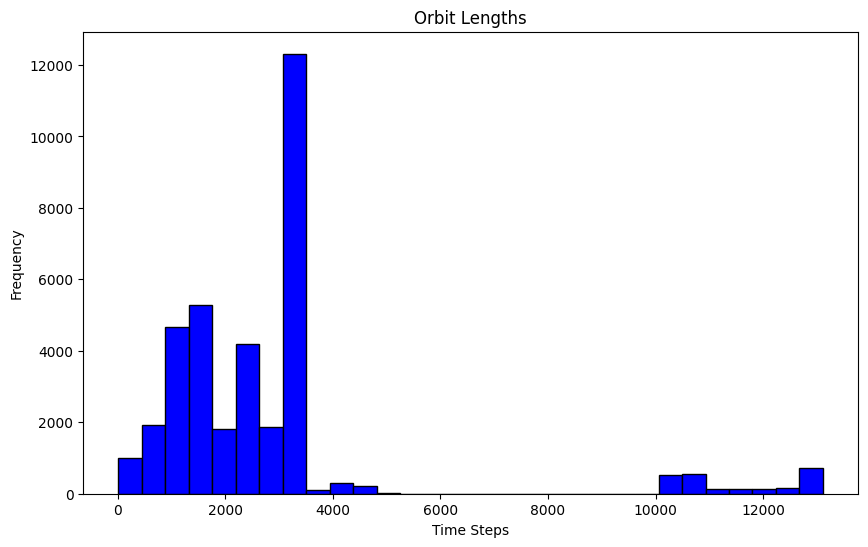

In [49]:
plot_orbit_data_lengths(orbit_data, title='Orbit Lengths')

In [56]:
len(periods)

36071

In [41]:
unique, counts = np.unique(periods, return_counts=True)
frequency_dict = dict(zip(unique, counts))
print(frequency_dict)

{1: 32, 2: 384, 3: 3111, 4: 9053, 5: 23491}


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()